# Oak Wilt Data Quality Assessment

This notebook analyzes the quality of oak wilt disease observations data, with special focus on coordinate validation.

In [30]:
!pip install geodatasets # seaborn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

## From the occurance data, extract data only for Minnesota

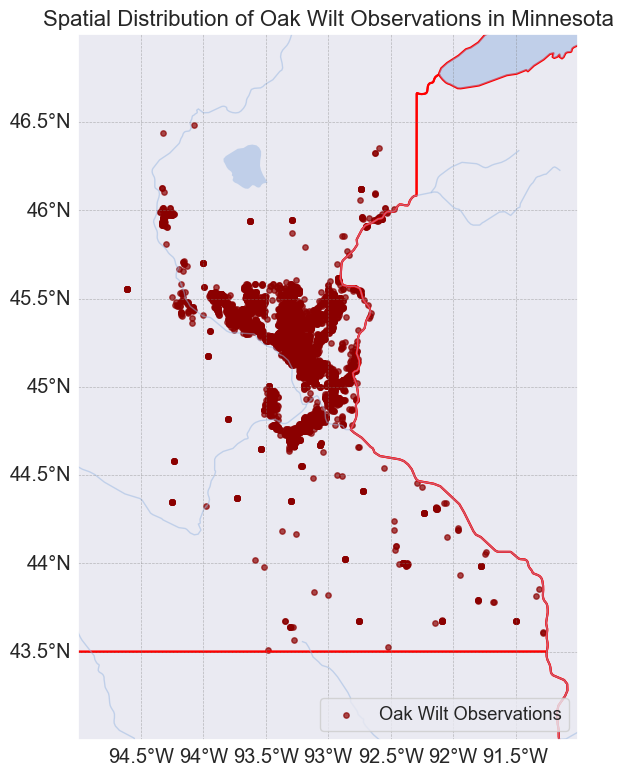

In [36]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the oak wilt observation data
oak_wilt_data = pd.read_csv("2024-10-22agg_17449_obs.csv")

# Filter for Minnesota data
minnesota_data = oak_wilt_data[oak_wilt_data['STATE'] == 'Minnesota']

# Convert to GeoDataFrame for plotting
minnesota_gdf = gpd.GeoDataFrame(
    minnesota_data, 
    geometry=gpd.points_from_xy(minnesota_data.Longitude, minnesota_data.Latitude),
    crs="EPSG:4326"
)

# Create the map
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add state boundaries with Minnesota highlighted
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
# Highlight Minnesota boundary by plotting it again with different params
ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='red', linewidth=1.5, facecolor='none')

# Plot the oak wilt observations
minnesota_gdf.plot(
    ax=ax,
    color='darkred',
    markersize=15,
    alpha=0.7,
    label="Oak Wilt Observations"
)

# Add other map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS, alpha=0.5)

# Set extent to Minnesota plus buffer
ax.set_extent([-95.0, -91.0, 43.0, 47.0], crs=ccrs.PlateCarree())

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add title and legend
plt.title('Spatial Distribution of Oak Wilt Observations in Minnesota', fontsize=16)
plt.legend(loc='lower right')

# Show plot
plt.tight_layout()
plt.savefig('minnesota_oak_wilt_distribution.png', dpi=300)
plt.show()

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from shapely.geometry import Point

# Step 1: Load and process the oak wilt observation data
print("Loading oak wilt observation data...")
oak_wilt_data = pd.read_csv("2024-10-22agg_17449_obs.csv")

# Filter for Minnesota and Wisconsin data
mn_wi_data = oak_wilt_data[oak_wilt_data['STATE'].isin(['Minnesota', 'Wisconsin'])]
minnesota_data = mn_wi_data[mn_wi_data['STATE'] == 'Minnesota']
wisconsin_data = mn_wi_data[mn_wi_data['STATE'] == 'Wisconsin']

print(f"Total Minnesota and Wisconsin data points: {len(mn_wi_data)}")
print(f"Minnesota points: {len(minnesota_data)}")
print(f"Wisconsin points: {len(wisconsin_data)}")

# Step 2: Load climate data
print("\nLoading climate data...")
climate_df = pd.read_csv('2024-10-29_oak_wilt_Normal_1961_1990.nrm.csv')
print(f"Climate data records: {len(climate_df)}")

# Step 3: Create a function to extract matching climate records
def extract_matching_climate_records(oak_wilt_df, climate_df, tolerance=0.01):
    """
    Extract climate records that match oak wilt locations.
    Returns exactly one climate record for each oak wilt record,
    including metadata fields from the oak wilt observations.
    """
    print(f"Processing {len(oak_wilt_df)} oak wilt records...")
    result_records = []
    
    for idx, oak_row in oak_wilt_df.iterrows():
        if idx % 1000 == 0:
            print(f"  Progress: {idx}/{len(oak_wilt_df)} records processed")
            
        oak_lat = oak_row['Latitude']
        oak_lon = oak_row['Longitude']
        
        # Calculate distance to all climate points
        climate_df['dist'] = np.sqrt(
            (climate_df['Latitude'] - oak_lat)**2 + 
            (climate_df['Longitude'] - oak_lon)**2
        )
        
        # Find the closest climate record
        closest_idx = climate_df['dist'].idxmin()
        climate_record = climate_df.loc[closest_idx].drop('dist').to_dict()
        
        # Add oak wilt metadata fields to the climate record
        for field in ['COUNTY', 'STATE', 'ObsDate', 'DateUp', 'DateEnt', 'KEY']:
            if field in oak_row:
                climate_record[f'oak_{field}'] = oak_row[field]
        
        result_records.append(climate_record)
    
    # Convert list of records to DataFrame
    result_df = pd.DataFrame(result_records)
    return result_df

# Step 4: Extract climate data for both states
print("\nExtracting climate data for Minnesota and Wisconsin...")
mn_wi_climate = extract_matching_climate_records(mn_wi_data, climate_df)

# Step 5: Save the combined data to CSV
output_file = 'mn_wi_climate_data.csv'
mn_wi_climate.to_csv(output_file, index=False)
print(f"\nSaved {len(mn_wi_climate)} combined climate records to {output_file}")

# Step 6: Create a GeoDataFrame for mapping
print("\nCreating map visualization...")
geometry = [Point(xy) for xy in zip(mn_wi_climate['Longitude'], mn_wi_climate['Latitude'])]
mn_wi_gdf = gpd.GeoDataFrame(mn_wi_climate, geometry=geometry, crs="EPSG:4326")

# Step 7: Create the map
fig, ax = plt.subplots(figsize=(14, 12), subplot_kw={'projection': ccrs.AlbersEqualArea(central_longitude=-92, central_latitude=45)})

# Add base map features
ax.add_feature(cfeature.LAND, facecolor='#f5f5f5')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.LAKES, facecolor='lightblue', edgecolor='gray')
ax.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')

# Plot points with different colors for each state
minnesota_gdf = mn_wi_gdf[mn_wi_gdf['oak_STATE'] == 'Minnesota']
wisconsin_gdf = mn_wi_gdf[mn_wi_gdf['oak_STATE'] == 'Wisconsin']

# Plot the points
ax.scatter(
    minnesota_gdf.geometry.x, minnesota_gdf.geometry.y,
    color='darkred', s=15, alpha=0.7, transform=ccrs.PlateCarree(),
    label="Minnesota Oak Wilt Observations"
)

ax.scatter(
    wisconsin_gdf.geometry.x, wisconsin_gdf.geometry.y,
    color='blue', s=15, alpha=0.7, transform=ccrs.PlateCarree(),
    label="Wisconsin Oak Wilt Observations"
)

# Set map extent to include both states plus buffer
ax.set_extent([-97.0, -87.0, 42.5, 47.5], crs=ccrs.PlateCarree())

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add title and legend
plt.title('Spatial Distribution of Oak Wilt Observations in Minnesota and Wisconsin', 
          fontsize=18, pad=20, fontweight='bold')
plt.legend(loc='lower right', fontsize=12, frameon=True, facecolor='white', edgecolor='lightgray')

# Add state labels
plt.text(-94.5, 46.0, 'MINNESOTA', transform=ccrs.PlateCarree(), 
         fontsize=14, fontweight='bold', alpha=0.7, ha='center')
plt.text(-90.0, 44.5, 'WISCONSIN', transform=ccrs.PlateCarree(), 
         fontsize=14, fontweight='bold', alpha=0.7, ha='center')

# Add scale bar
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=10)
scalebar = AnchoredSizeBar(ax.transData,
                           100000,  # 100 km in meters
                           '100 km',
                           'lower center',
                           pad=0.5,
                           color='black',
                           frameon=True,
                           size_vertical=2000,
                           fontproperties=fontprops)
ax.add_artist(scalebar)

# Add north arrow
from matplotlib.patches import FancyArrowPatch
arrow = FancyArrowPatch((0.05, 0.05), (0.05, 0.15), 
                       transform=fig.transFigure,
                       color='black', 
                       arrowstyle='->', 
                       mutation_scale=20)
fig.patches.append(arrow)
plt.figtext(0.05, 0.17, 'N', ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('mn_wi_oak_wilt_map.png', dpi=300, bbox_inches='tight')
print(f"Map saved as: mn_wi_oak_wilt_map.png")
plt.show()

print("\nProcess completed successfully!")

## From the compiled data with climate variables, extract only the Minnesata State points

In [2]:
import pandas as pd
import numpy as np

# Load the datasets
oak_wilt_data = pd.read_csv("2024-10-22agg_17449_obs.csv")
climate_df = pd.read_csv('2024-10-29_oak_wilt_Normal_1961_1990.nrm.csv')

# Filter for Minnesota data
minnesota_data = oak_wilt_data[oak_wilt_data['STATE'] == 'Minnesota']
print(f"Minnesota oak wilt data: {len(minnesota_data)} records")
print(f"Climate data fields: {len(climate_df.columns)}")

# Create a function to extract matching climate records and merge with oak wilt metadata
def extract_matching_climate_records(oak_wilt_df, climate_df, tolerance=0.01):
    """
    Extract climate records that match the Minnesota oak wilt locations.
    Returns exactly one climate record for each oak wilt record,
    including metadata fields from the oak wilt observations.
    """
    # For each Minnesota oak wilt record, find the closest climate record
    result_records = []
    
    for idx, oak_row in oak_wilt_df.iterrows():
        oak_lat = oak_row['Latitude']
        oak_lon = oak_row['Longitude']
        
        # Calculate distance to all climate points
        climate_df['dist'] = np.sqrt(
            (climate_df['Latitude'] - oak_lat)**2 + 
            (climate_df['Longitude'] - oak_lon)**2
        )
        
        # Find the closest climate record
        closest_idx = climate_df['dist'].idxmin()
        climate_record = climate_df.loc[closest_idx].drop('dist').to_dict()
        
        # Add oak wilt metadata fields to the climate record
        for field in ['COUNTY', 'ObsDate', 'DateUp', 'DateEnt', 'KEY']:
            if field in oak_row:
                climate_record[f'oak_{field}'] = oak_row[field]
        
        result_records.append(climate_record)
    
    # Convert list of records to DataFrame
    result_df = pd.DataFrame(result_records)
    return result_df

# Extract matching climate records with oak wilt metadata
minnesota_climate = extract_matching_climate_records(minnesota_data, climate_df)

# Verify we have the correct number of records
print(f"Extracted {len(minnesota_climate)} climate records")
print(f"Number of fields in extracted data: {len(minnesota_climate.columns)}")

# Save to CSV
output_file = 'minnesota_climate_data.csv'
minnesota_climate.to_csv(output_file, index=False)
print(f"Saved {len(minnesota_climate)} Minnesota climate records to {output_file}")

Minnesota oak wilt data: 9880 records
Climate data fields: 270
Extracted 9880 climate records
Number of fields in extracted data: 275
Saved 9880 Minnesota climate records to minnesota_climate_data.csv


## 1. Load and Inspect the extracted compiled Data both have oak location and environment variables

In [48]:
# Load the data
df = pd.read_csv('minnesota_climate_data.csv')

print(f"Loaded {len(df)} records from the dataset")

# Display basic dataset info
print(f"Number of fields: {len(df.columns)}")
df.info()

Loaded 9880 records from the dataset
Number of fields: 275
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9880 entries, 0 to 9879
Columns: 275 entries, id1 to oak_KEY
dtypes: float64(270), object(5)
memory usage: 20.7+ MB


In [ ]:
# View the first few records
# df.head()
!pip install xgboost

In [50]:
# Check overall missing values
missing_values = df.isnull().sum()
missing_percentages = (missing_values / len(df)) * 100

# Combine into a DataFrame for easier viewing
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentages
}).sort_values('Missing Values', ascending=False)

# Only show fields with missing values
missing_df = missing_df[missing_df['Missing Values'] > 0]

print(f"Found {len(missing_df)} columns with missing values")
missing_df.head(20)  # Show top 20 fields with missing values

Found 1 columns with missing values


,Missing Values,Percentage
oak_ObsDate,30,0.303644


## 3. Check for Records with Missing Coordinates

In [51]:
# Make sure lat/lng are numeric
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

# Check for missing or invalid coordinates
missing_lat = df['Latitude'].isna()
missing_lng = df['Longitude'].isna()
invalid_lat = (df['Latitude'] < -90) | (df['Latitude'] > 90)
invalid_lng = (df['Longitude'] < -180) | (df['Longitude'] > 180)

# Combine to find all problematic coordinates
problematic_coords = missing_lat | missing_lng | invalid_lat | invalid_lng

# Create a new DataFrame with all problematic records
problematic_df = df[problematic_coords].copy()

# Add a column indicating the problem type
problematic_df['Problem Type'] = 'Multiple Issues'
problematic_df.loc[missing_lat & ~missing_lng & ~invalid_lng, 'Problem Type'] = 'Missing Latitude'
problematic_df.loc[~missing_lat & missing_lng & ~invalid_lat, 'Problem Type'] = 'Missing Longitude'
problematic_df.loc[missing_lat & missing_lng, 'Problem Type'] = 'Missing Both Coordinates'
problematic_df.loc[~missing_lat & ~missing_lng & invalid_lat & ~invalid_lng, 'Problem Type'] = 'Invalid Latitude'
problematic_df.loc[~missing_lat & ~missing_lng & ~invalid_lat & invalid_lng, 'Problem Type'] = 'Invalid Longitude'

print(f"Found {len(problematic_df)} records with problematic coordinates out of {len(df)} total records")
print(f"Percentage of records with problematic coordinates: {len(problematic_df) / len(df) * 100:.2f}%")

# Show a summary of problem types
problem_summary = problematic_df['Problem Type'].value_counts().reset_index()
problem_summary.columns = ['Problem Type', 'Count']
print("\nSummary of coordinate problems:")
print(problem_summary)

# Display problematic records
if not problematic_df.empty:
    cols_to_display = ['objectid', 'Location', 'Latitude', 'Longitude', 'STATE', 'County', 'Problem Type']
    display(problematic_df[cols_to_display].head(20))
    
    # Group by state to see distribution
    state_summary = problematic_df['STATE'].value_counts().reset_index()
    state_summary.columns = ['STATE', 'Problematic Coordinate Count']
    print("\nDistribution of problematic coordinates by state:")
    print(state_summary)

Found 0 records with problematic coordinates out of 9880 total records
Percentage of records with problematic coordinates: 0.00%

Summary of coordinate problems:
Empty DataFrame
Columns: [Problem Type, Count]
Index: []


## 4. Check for Invalid Coordinate Values

In [52]:
# Make sure lat/lng are numeric
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

# Check for missing or invalid coordinates
missing_lat = df['Latitude'].isna()
missing_lng = df['Longitude'].isna()
invalid_lat = (df['Latitude'] < -90) | (df['Latitude'] > 90)
invalid_lng = (df['Longitude'] < -180) | (df['Longitude'] > 180)

# Combine to find all problematic coordinates
problematic_coords = missing_lat | missing_lng | invalid_lat | invalid_lng

# Create a new DataFrame with all problematic records
problematic_df = df[problematic_coords].copy()

# Add a column indicating the problem type
problematic_df['Problem Type'] = 'Multiple Issues'
problematic_df.loc[missing_lat & ~missing_lng & ~invalid_lng, 'Problem Type'] = 'Missing Latitude'
problematic_df.loc[~missing_lat & missing_lng & ~invalid_lat, 'Problem Type'] = 'Missing Longitude'
problematic_df.loc[missing_lat & missing_lng, 'Problem Type'] = 'Missing Both Coordinates'
problematic_df.loc[~missing_lat & ~missing_lng & invalid_lat & ~invalid_lng, 'Problem Type'] = 'Invalid Latitude'
problematic_df.loc[~missing_lat & ~missing_lng & ~invalid_lat & invalid_lng, 'Problem Type'] = 'Invalid Longitude'

print(f"Found {len(problematic_df)} records with problematic coordinates out of {len(df)} total records")
print(f"Percentage of records with problematic coordinates: {len(problematic_df) / len(df) * 100:.2f}%")

# Show a summary of problem types
problem_summary = problematic_df['Problem Type'].value_counts().reset_index()
problem_summary.columns = ['Problem Type', 'Count']
print("\nSummary of coordinate problems:")
print(problem_summary)

# Display problematic records
if not problematic_df.empty:
    cols_to_display = ['objectid', 'Location', 'Latitude', 'Longitude', 'STATE', 'County', 'Problem Type']
    display(problematic_df[cols_to_display].head(20))
    
    # Group by state to see distribution
    state_summary = problematic_df['STATE'].value_counts().reset_index()
    state_summary.columns = ['STATE', 'Problematic Coordinate Count']
    print("\nDistribution of problematic coordinates by state:")
    print(state_summary)

Found 0 records with problematic coordinates out of 9880 total records
Percentage of records with problematic coordinates: 0.00%

Summary of coordinate problems:
Empty DataFrame
Columns: [Problem Type, Count]
Index: []


In [ ]:
# !pip install contextily
!pip install cartopy

## 5. Visualize Coordinate Distribution Showing data with County boundary

Working with 9987 Minnesota points


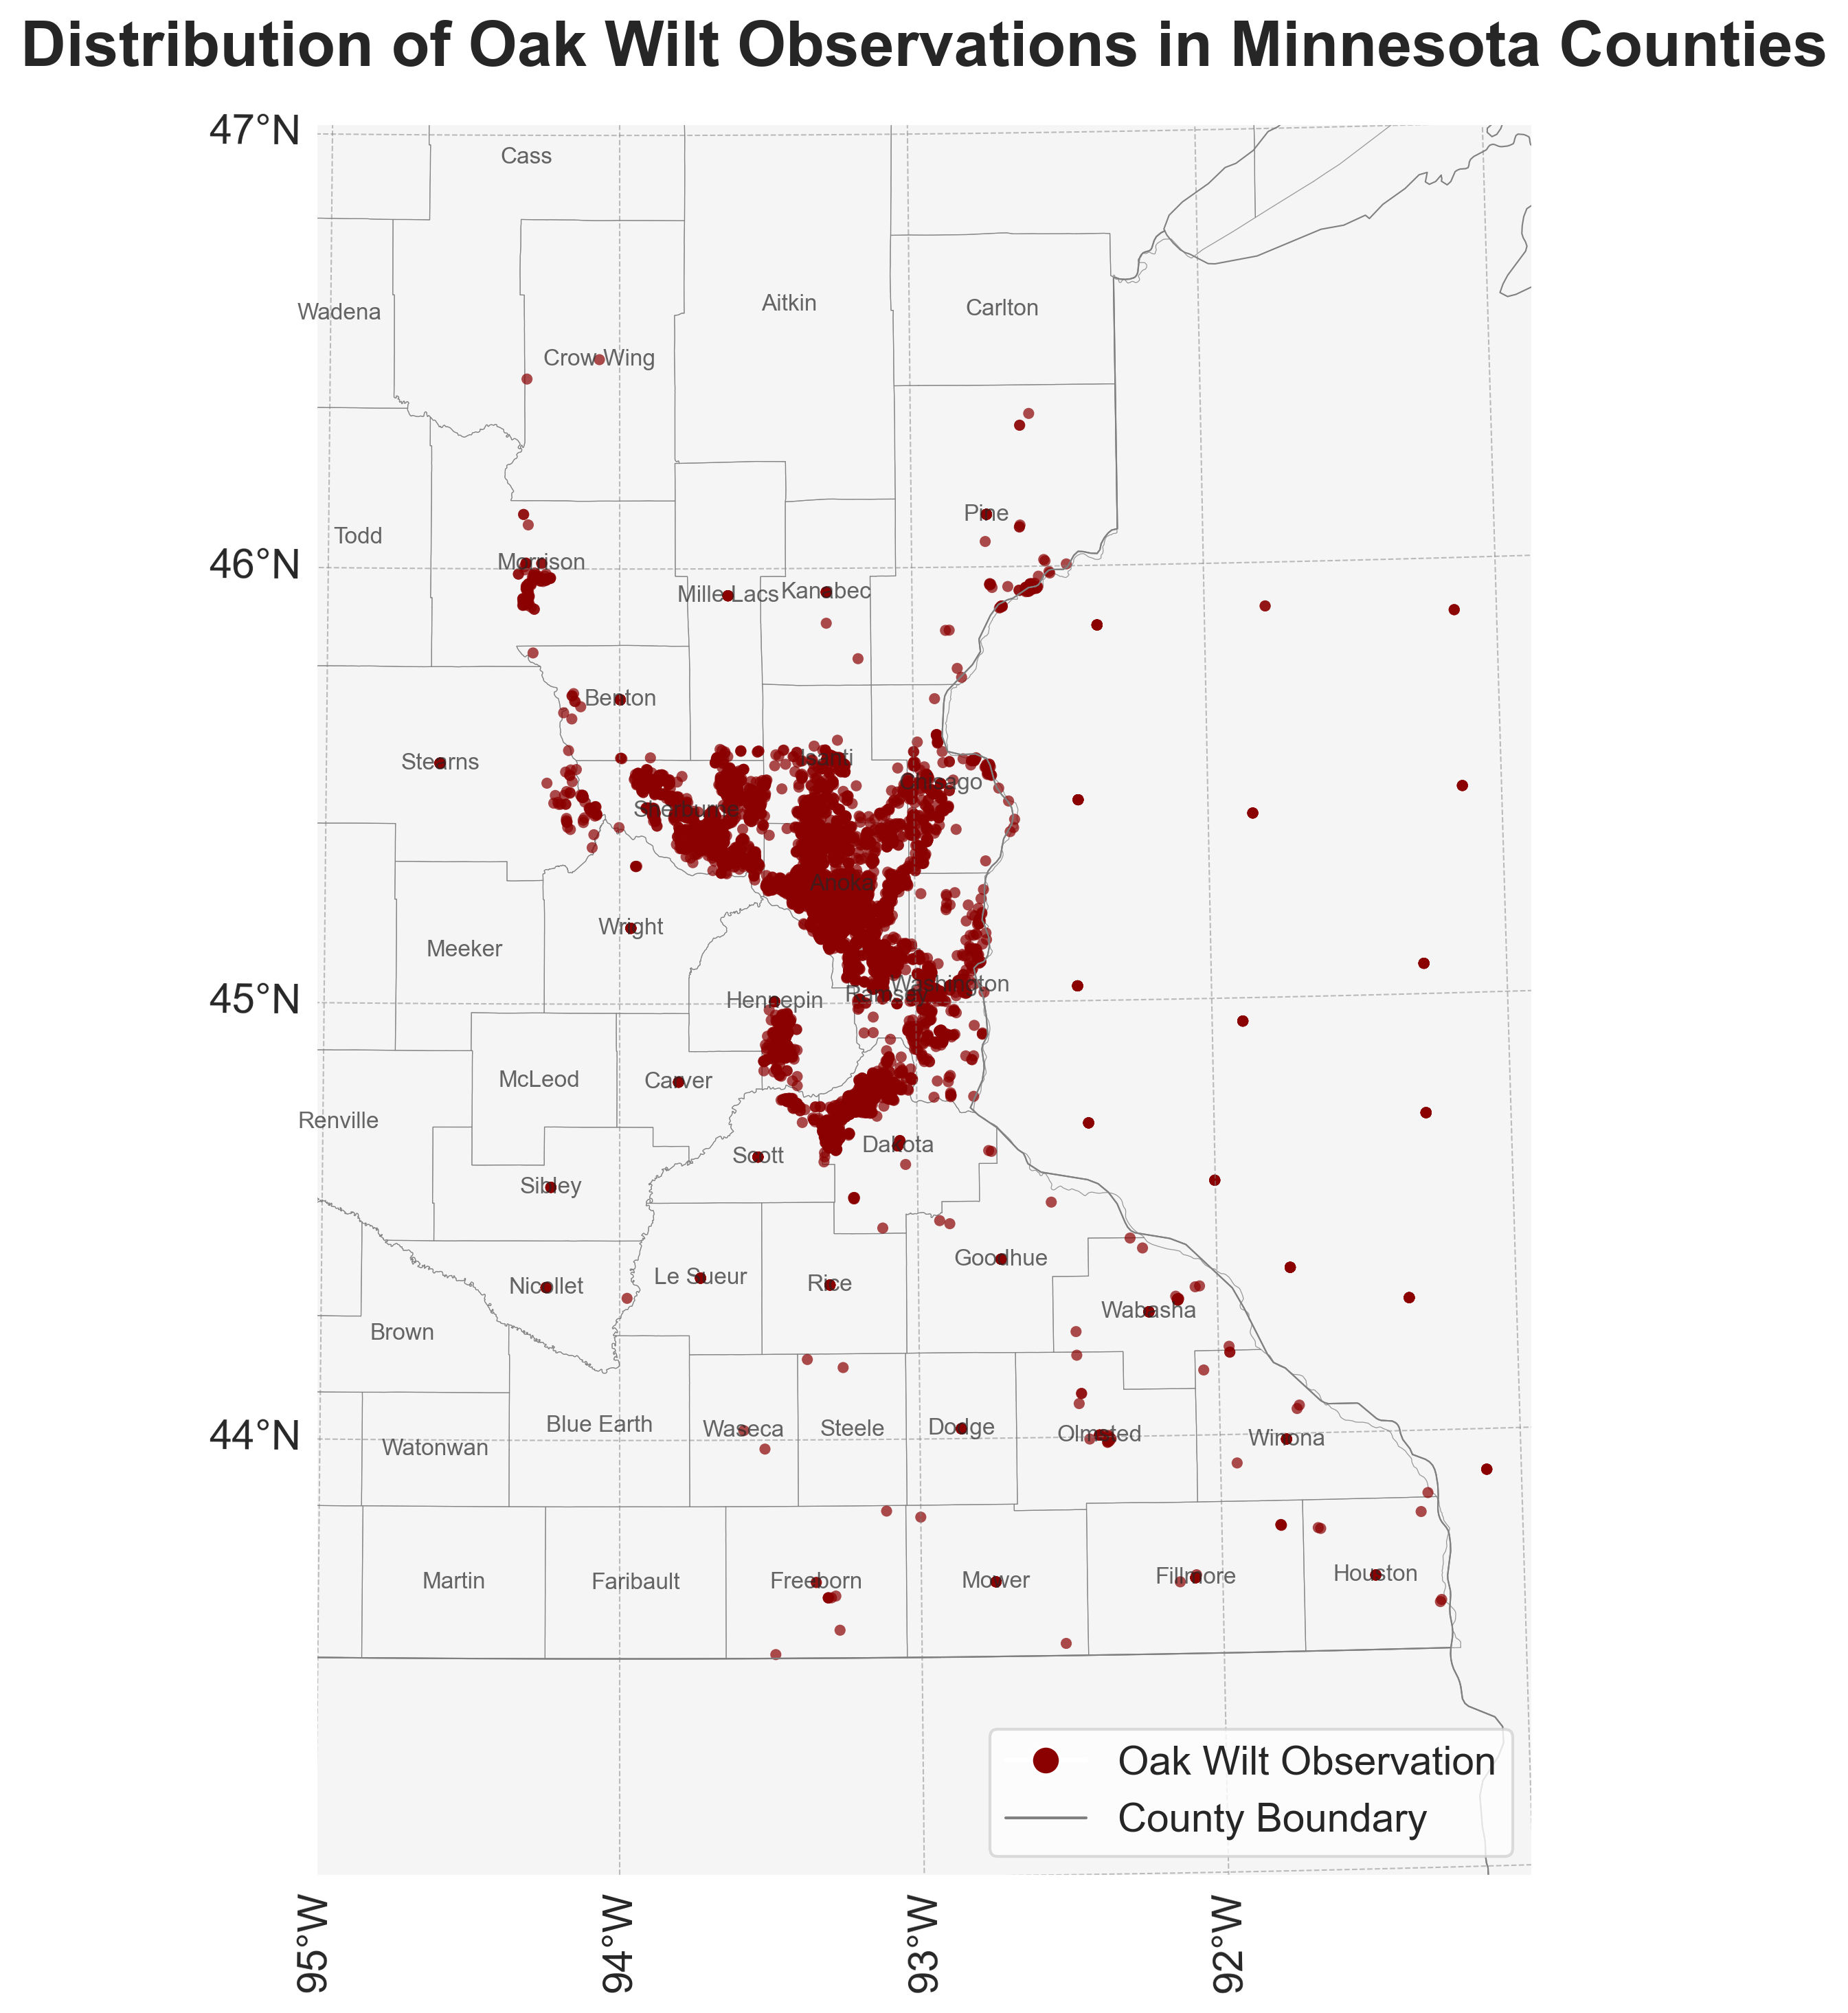

In [63]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from scipy.stats import gaussian_kde
from shapely.geometry import Point

# Minnesota bounding box coordinates
MIN_LAT, MAX_LAT = 43.0, 47.0
MIN_LON, MAX_LON = -95.0, -91.0

# Load the CSV file
df = pd.read_csv('mn_wi_climate_data.csv')

# Filter points within Minnesota's bounding box
minnesota_mask = (
    (df['Latitude'] >= MIN_LAT) & 
    (df['Latitude'] <= MAX_LAT) & 
    (df['Longitude'] >= MIN_LON) & 
    (df['Longitude'] <= MAX_LON)
)
mn_df = df[minnesota_mask].copy()

# Create geometry column
geometry = [Point(xy) for xy in zip(mn_df['Longitude'], mn_df['Latitude'])]
minnesota_gdf = gpd.GeoDataFrame(mn_df, geometry=geometry, crs='EPSG:4326')

print(f"Working with {len(minnesota_gdf)} Minnesota points")

# Load Minnesota county boundaries
# You can download this file from the US Census Bureau or TIGER/Line shapefiles
# https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html
counties = gpd.read_file('https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/us-county-boundaries/exports/geojson?lang=en&refine=statefp%3A27')  # 27 is the FIPS code for Minnesota

# Create a map visualization
plt.figure(figsize=(14, 10), dpi=300)
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-94, central_latitude=46))

# Add map features
ax.add_feature(cfeature.LAND, facecolor='#f5f5f5')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linewidth=1)

# Add county boundaries
counties.to_crs(ccrs.PlateCarree()).plot(
    ax=ax,
    edgecolor='gray',
    facecolor='none',
    linewidth=0.3,
    alpha=0.8,
    transform=ccrs.PlateCarree()
)

# Plot Minnesota points
plt.scatter(minnesota_gdf['Longitude'], minnesota_gdf['Latitude'],
            alpha=0.7, c='darkred', s=15,
            edgecolor='none',
            transform=ccrs.PlateCarree())

# Set map extent to Minnesota focus area
ax.set_extent([MIN_LON, MAX_LON, MIN_LAT, MAX_LAT], crs=ccrs.PlateCarree())

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.title('Distribution of Oak Wilt Observations in Minnesota Counties', 
          fontsize=22, pad=20, fontweight='bold')

# Add county labels (optional)
for idx, row in counties.iterrows():
    # Get county center for label placement
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    # Only add labels for counties in the visible area
    if (x >= MIN_LON and x <= MAX_LON and y >= MIN_LAT and y <= MAX_LAT):
        plt.text(x, y, row['name'], fontsize=8, ha='center', va='center',
                transform=ccrs.PlateCarree(), alpha=0.7)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='darkred',
                        markersize=10, label='Oak Wilt Observation'),
                  Line2D([0], [0], color='gray', lw=1, label='County Boundary')]
ax.legend(handles=legend_elements, loc='lower right', fontsize=14,
         frameon=True, facecolor='white', edgecolor='lightgray')

plt.tight_layout()
plt.savefig('oak_wilt_minnesota_counties_map.png', dpi=300, bbox_inches='tight')
plt.show()

## Generating the Grid for the covering area (also with a CSV file with presense and non-oresence value)

Loading climate data with oak wilt observations...
Loaded 10365 records
Extent in UTM coordinates: 374090.624545751, 4725757.535074168, 910228.6131681146, 5148204.631629368
Grid dimensions: 112 x 89 cells
Cells with oak wilt presence: 390 of 9968
Maximum points in a single cell: 603
Saved raster to oak_wilt_presence_10km_grid.tif
Saved shapefile to oak_wilt_presence_5km_grid.shp


/var/folders/9j/c9crymz15cq56v_gpknqd0n80000gn/T/ipykernel_16660/1973798882.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  grid_gdf.to_file('oak_wilt_presence_5km_grid.shp')
/Users/peteryang/miniconda3/envs/geoenv/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'point_count' to 'point_coun'
  ogr_write(


Saved map to oak_wilt_presence_grid_map.png


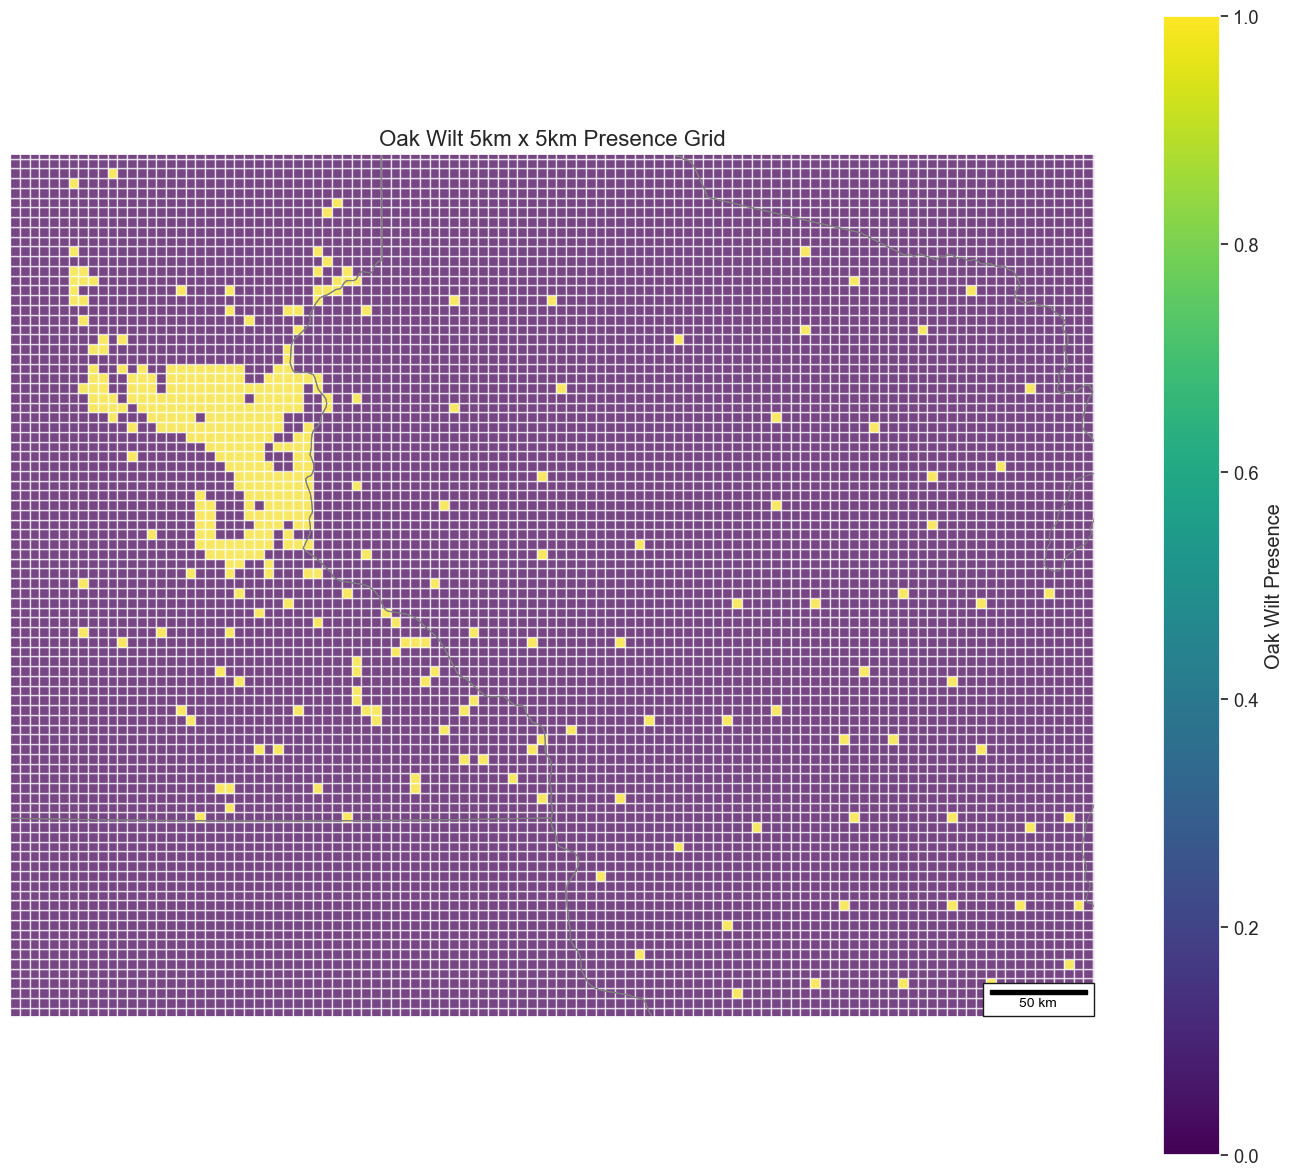

Saved grid data to oak_wilt_10km_grid.csv
Process completed successfully!


In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point, Polygon
import rasterio
from rasterio.transform import from_origin

# Load the combined Minnesota and Wisconsin data
print("Loading climate data with oak wilt observations...")
mn_wi_data = pd.read_csv('mn_wi_climate_data.csv')
print(f"Loaded {len(mn_wi_data)} records")

# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(mn_wi_data['Longitude'], mn_wi_data['Latitude'])]
gdf = gpd.GeoDataFrame(mn_wi_data, geometry=geometry, crs="EPSG:4326")

# Reproject to a meter-based CRS for accurate grid cell size
# UTM Zone 15N is appropriate for Minnesota/Wisconsin
gdf_projected = gdf.to_crs("EPSG:26915")  # UTM Zone 15N

# Define grid parameters
cell_size = 5000  # 5 km in meters
x_min, y_min, x_max, y_max = gdf_projected.total_bounds
print(f"Extent in UTM coordinates: {x_min}, {y_min}, {x_max}, {y_max}")

# Add a buffer to ensure we cover the entire area
buffer = cell_size * 2  # 20 km buffer
x_min -= buffer
y_min -= buffer
x_max += buffer
y_max += buffer

# Calculate number of cells
num_cells_x = int(np.ceil((x_max - x_min) / cell_size))
num_cells_y = int(np.ceil((y_max - y_min) / cell_size))
print(f"Grid dimensions: {num_cells_x} x {num_cells_y} cells")

# Create grid cells as polygons
grid_cells = []
for i in range(num_cells_x):
    for j in range(num_cells_y):
        # Calculate cell coordinates
        x0 = x_min + i * cell_size
        y0 = y_min + j * cell_size
        x1 = x0 + cell_size
        y1 = y0 + cell_size
        
        # Create polygon
        grid_cells.append({
            'geometry': Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)]),
            'cell_id': f"x{i}y{j}",
            'x_index': i,
            'y_index': j
        })

# Create a GeoDataFrame from the grid cells
grid_gdf = gpd.GeoDataFrame(grid_cells, crs="EPSG:26915")

# Initialize all cells with value 0
grid_gdf['value'] = 0

# Perform spatial join to find which grid cells contain oak wilt points
joined = gpd.sjoin(grid_gdf, gdf_projected, how='left', predicate='contains')

# Set value to 1 for cells that contain at least one oak wilt point
grid_gdf['value'] = np.where(grid_gdf['cell_id'].isin(joined[joined['index_right'].notna()]['cell_id']), 1, 0)

# Count points per cell for reference
point_counts = joined.groupby('cell_id').size().reset_index(name='point_count')
grid_gdf = grid_gdf.merge(point_counts, on='cell_id', how='left')
grid_gdf['point_count'] = grid_gdf['point_count'].fillna(0).astype(int)

print(f"Cells with oak wilt presence: {grid_gdf['value'].sum()} of {len(grid_gdf)}")
print(f"Maximum points in a single cell: {grid_gdf['point_count'].max()}")

# Create a raster from the grid
# Create a 2D array to hold the grid values
grid_array = np.zeros((num_cells_y, num_cells_x), dtype=np.uint8)

# Fill the array with the grid values
for _, row in grid_gdf.iterrows():
    i, j = row['x_index'], row['y_index']
    grid_array[num_cells_y - 1 - j, i] = row['value']  # Flip y axis to match raster convention

# Save the raster
output_raster = 'oak_wilt_presence_10km_grid.tif'
transform = from_origin(x_min, y_max, cell_size, cell_size)

with rasterio.open(
    output_raster,
    'w',
    driver='GTiff',
    height=grid_array.shape[0],
    width=grid_array.shape[1],
    count=1,
    dtype=grid_array.dtype,
    crs="EPSG:26915",
    transform=transform,
) as dst:
    dst.write(grid_array, 1)

print(f"Saved raster to {output_raster}")

# Save the grid as shapefile with presence/absence values
grid_gdf.to_file('oak_wilt_presence_5km_grid.shp')
print(f"Saved shapefile to oak_wilt_presence_5km_grid.shp")

# Create a visualization
fig, ax = plt.subplots(figsize=(14, 12), subplot_kw={'projection': ccrs.UTM(15)})

# Instead of using the deprecated datasets function, use cartopy directly
ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor='gray')

# Plot the grid cells colored by presence/absence
grid_gdf.plot(
    column='value',
    ax=ax,
    cmap='viridis',
    alpha=0.7,
    legend=True,
    legend_kwds={'label': "Oak Wilt Presence"}
)

# Set the extent
ax.set_extent([x_min, x_max, y_min, y_max], crs=ccrs.UTM(15))

# Add title
plt.title('Oak Wilt 5km x 5km Presence Grid', fontsize=16)

# Add scale bar
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=10)
scalebar = AnchoredSizeBar(ax.transData,
                           50000,  # 50 km
                           '50 km',
                           'lower right',
                           pad=0.5,
                           color='black',
                           frameon=True,
                           size_vertical=2000,
                           fontproperties=fontprops)
ax.add_artist(scalebar)

plt.tight_layout()
plt.savefig('oak_wilt_presence_grid_map.png', dpi=300)
print(f"Saved map to oak_wilt_presence_grid_map.png")
plt.show()

# Create a CSV version of the grid with coordinates and presence/absence values
grid_df = pd.DataFrame({
    'cell_id': grid_gdf['cell_id'],
    'x_center': grid_gdf.geometry.centroid.x,
    'y_center': grid_gdf.geometry.centroid.y,
    'presence': grid_gdf['value'],
    'point_count': grid_gdf['point_count']
})

# Save to CSV
grid_df.to_csv('oak_wilt_5km_grid.csv', index=False)
print(f"Saved grid data to oak_wilt_5km_grid.csv")

print("Process completed successfully!")

In [81]:
# !pip install shap
#!pip install pandas numpy matplotlib seaborn scikit-learn xgboost 
!pip install numpy==2.1
# !pip uninstall numpy -y

160063.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Using cached numpy-2.1.0-cp310-cp310-macosx_14_0_arm64.whl.metadata (60 kB)
Using cached numpy-2.1.0-cp310-cp310-macosx_14_0_arm64.whl (5.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
segment-geospatial 0.12.3 requires sam2, which is not installed.


## Oak wilt Traning Data Preparation (based on the decided 28 varialbes and a 5km grid)

In [ ]:
## An updated version of the above preparation since I got some warnings
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

# Define the variables we want to extract for the model
selected_variables = [
    # Geographic coordinates
    'Latitude', 'Longitude',
    
    # Temperature variables (seasonal extremes important for fungal spread)
    'Tmin01',  # Winter minimum temperature  
    'Tmax07',  # Summer maximum temperature
    'TD',      # Temperature difference/continentality
    
    # Precipitation and moisture variables
    'MAP',     # Mean annual precipitation
    'PAS',     # Precipitation as snow
    'AHM',     # Annual heat-moisture index
    'PPT01',   # Winter precipitation
    'PPT07',   # Summer precipitation
    'CMD01',   # Winter moisture deficit
    
    # Humidity variables (affect fungal spore viability)
    'RH01',    # Winter relative humidity
    'RH07',    # Summer relative humidity
    
    # Growing season variables (critical for vector activity)
    'NFFD',    # Number of frost-free days
    'DD_0_01', # Degree-days below 0°C
    'DD5_07',  # Growing degree-days above 5°C
    'DD_18_07', # Degree-days above 18°C
    
    # Radiation and evaporation (influence moisture conditions)
    'Rad01',   # Winter radiation
    'Rad07',   # Summer radiation
    'Eref01',  # Winter reference evaporation
    'Eref07',  # Summer reference evaporation
    
    # From your expanded variable list (low correlation)
    'PAS09',   # Fall snow precipitation
    'PAS04',   # Spring snow precipitation
    'DD_0_04', # Spring degree-days below 0
    'DD_0_10', # Fall degree-days below 0
    'MAR',     # Mean annual radiation
    'NFFD10',  # Number of frost-free days (October)
    'RH08',    # Late summer humidity
]

# STEP 1: Load the climate data
print("Loading climate data...")
climate_data = pd.read_csv('mn_wi_climate_data.csv')
print(f"Loaded {len(climate_data)} climate data records")

# STEP 2: Load the generated grid data 
print("Loading oak wilt presence grid data...")
grid_data = pd.read_csv('oak_wilt_5km_grid.csv')
print(f"Loaded {len(grid_data)} grid cells")

# STEP 3: Create spatial joins to associate climate variables with grid cells
# Create GeoDataFrame from climate data
climate_gdf = gpd.GeoDataFrame(
    climate_data,
    geometry=[Point(xy) for xy in zip(climate_data['Longitude'], climate_data['Latitude'])],
    crs="EPSG:4326"
)

# Create GeoDataFrame from grid data
# If the grid data doesn't have a geometry column already, create it from the centroid coordinates
grid_gdf = gpd.GeoDataFrame(
    grid_data,
    geometry=[Point(xy) for xy in zip(grid_data['x_center'], grid_data['y_center'])],
    crs="EPSG:26915"  # UTM Zone 15N as in your original code
)

# Reproject to the same coordinate system for the join
grid_gdf = grid_gdf.to_crs("EPSG:4326")

# STEP 4: For each grid cell, find the nearest climate data point and assign its values
# This approach works well if your climate data has a higher resolution than your grid
print("Associating climate variables with grid cells...")

# Initialize a dataframe to store the results
training_data = pd.DataFrame()
training_data['cell_id'] = grid_data['cell_id']
training_data['presence'] = grid_data['presence']
training_data['point_count'] = grid_data['point_count']

# For each grid cell, find the nearest climate data point
for idx, grid_cell in grid_gdf.iterrows():
    # Calculate distances to all climate points
    distances = climate_gdf.geometry.distance(grid_cell.geometry)
    nearest_idx = distances.idxmin()
    
    # Get the climate data for the nearest point
    nearest_climate = climate_data.loc[nearest_idx]
    
    # Add the selected variables to the training data
    for var in selected_variables:
        if var not in training_data.columns:
            training_data[var] = np.nan
        training_data.at[idx, var] = nearest_climate[var]
    
    # Print progress every 100 cells
    if idx % 100 == 0:
        print(f"Processed {idx} of {len(grid_gdf)} grid cells")

# STEP 5: Save the training dataset
print("Saving training dataset...")
training_data.to_csv('oak_wilt_training_data.csv', index=False)
print(f"Saved training dataset with {len(training_data)} samples and {len(training_data.columns)} variables")

# STEP 6: Data checks and summary
print("\nData summary:")
print(f"Number of samples: {len(training_data)}")
print(f"Number of positive samples (presence=1): {training_data['presence'].sum()}")
print(f"Number of negative samples (presence=0): {len(training_data) - training_data['presence'].sum()}")
print(f"Presence ratio: {training_data['presence'].mean():.2%}")

# Check for missing values
missing_values = training_data[selected_variables].isnull().sum()
if missing_values.any():
    print("\nWarning: Missing values detected in the following variables:")
    print(missing_values[missing_values > 0])
else:
    print("\nNo missing values in the selected variables.")

print("\nTraining data preparation completed!")

## Oak Wilt Model Training and Evalation

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from scipy.spatial.distance import cdist

# Load your presence data
presence_df = pd.read_csv('oak_wilt_model_data_28variables.csv')
presence_df['presence'] = 1

# Extract the geographic and climate features
geo_cols = ['Latitude', 'Longitude']
feature_cols = [col for col in presence_df.columns if col not in ['presence', 'Latitude', 'Longitude', 'dataset']]

# Define study area boundaries
min_lon, max_lon = presence_df['Longitude'].min(), presence_df['Longitude'].max()
min_lat, max_lat = presence_df['Latitude'].min(), presence_df['Latitude'].max()

# 1. IMPROVED PSEUDO-ABSENCE GENERATION
np.random.seed(42)
num_pseudo_absences = len(presence_df)  # 1:1 ratio

# Generate initial random points
candidate_points = []
num_candidates = num_pseudo_absences * 10  # Generate 10x more candidates than needed
candidate_lat = np.random.uniform(min_lat, max_lat, num_candidates)
candidate_lon = np.random.uniform(min_lon, max_lon, num_candidates)

# Calculate distances from each candidate point to the nearest presence point
presence_coords = presence_df[geo_cols].values
candidate_coords = np.column_stack((candidate_lat, candidate_lon))

# Calculate minimum distance from each candidate to any presence point
min_distances = []
for c in candidate_coords:
    dists = np.sqrt(((presence_coords - c)**2).sum(axis=1))
    min_distances.append(np.min(dists))

# Sort candidates by distance and select the furthest ones
sorted_indices = np.argsort(min_distances)[::-1]  # Descending order
selected_indices = sorted_indices[:num_pseudo_absences]

# Create pseudo-absence dataframe with the selected points
pseudo_absence_df = pd.DataFrame({
    'Latitude': candidate_lat[selected_indices],
    'Longitude': candidate_lon[selected_indices],
    'presence': 0
})

# Extract climate variables for pseudo-absence points
# In a real implementation, you would extract values from raster layers
# Here's a simulation using inverse distance weighting
for col in feature_cols:
    values = []
    for i, point in pseudo_absence_df[geo_cols].iterrows():
        # Calculate distances to all presence points
        dists = np.sqrt(((presence_coords - [point['Latitude'], point['Longitude']])**2).sum(axis=1))
        
        # Apply inverse distance weighting with added noise
        weights = 1.0 / (dists + 0.001)  # Add small constant to avoid division by zero
        weights = weights / np.sum(weights)
        
        # Calculate weighted average
        weighted_value = np.sum(weights * presence_df[col].values)
        
        # Add random noise scaled by the standard deviation of the feature
        std_dev = presence_df[col].std()
        noise = np.random.normal(0, std_dev * 0.2)  # Reduced noise factor
        
        values.append(weighted_value + noise)
    
    pseudo_absence_df[col] = values

# 2. SPATIAL CROSS-VALIDATION
# Create spatial clusters for validation
from sklearn.cluster import KMeans

# Combine the datasets
combined_df = pd.concat([presence_df, pseudo_absence_df], ignore_index=True)

# Create spatial clusters for validation
n_clusters = 5  # Number of spatial folds
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
combined_df['spatial_fold'] = kmeans.fit_predict(combined_df[geo_cols])

# Plot the spatial folds
plt.figure(figsize=(12, 8))
for fold in range(n_clusters):
    fold_data = combined_df[combined_df['spatial_fold'] == fold]
    plt.scatter(fold_data['Longitude'], fold_data['Latitude'], 
                label=f'Fold {fold+1}', alpha=0.7)

plt.title('Spatial Cross-Validation Folds')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('spatial_cv_folds.png')
plt.close()

# Initialize models with more complex parameters
models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=500, 
                                          max_depth=None, min_samples_split=5,
                                          class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, n_estimators=500, 
                            learning_rate=0.01, max_depth=7,
                            colsample_bytree=0.8),
    'SVM': SVC(probability=True, random_state=42, C=10, gamma='scale'),
    'Neural Network': MLPClassifier(random_state=42, max_iter=2000, 
                                  hidden_layer_sizes=(100, 50), 
                                  early_stopping=True, alpha=0.001)
}

# Track results across folds
cv_results = {name: {'accuracy': [], 'kappa': [], 'auc': []} for name in models.keys()}

# Perform spatial cross-validation
X = combined_df[feature_cols]
y = combined_df['presence']
groups = combined_df['spatial_fold']

# Initialize spatial GroupKFold
gkf = GroupKFold(n_splits=n_clusters)

print("Performing spatial cross-validation...")

for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\nFold {fold+1}/{n_clusters}")
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"  Training {name}...")
        
        # Train the model
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        kappa = cohen_kappa_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        
        # Store results for this fold
        cv_results[name]['accuracy'].append(accuracy)
        cv_results[name]['kappa'].append(kappa)
        cv_results[name]['auc'].append(auc)
        
        print(f"    {name} - Accuracy: {accuracy:.4f}, Kappa: {kappa:.4f}, AUC: {auc:.4f}")

# Calculate average results across folds
print("\nAverage model performance across all folds:")
for name in models.keys():
    avg_accuracy = np.mean(cv_results[name]['accuracy'])
    avg_kappa = np.mean(cv_results[name]['kappa'])
    avg_auc = np.mean(cv_results[name]['auc'])
    
    std_accuracy = np.std(cv_results[name]['accuracy'])
    std_kappa = np.std(cv_results[name]['kappa'])
    std_auc = np.std(cv_results[name]['auc'])
    
    print(f"{name}:")
    print(f"  Accuracy: {avg_accuracy:.4f} (±{std_accuracy:.4f})")
    print(f"  Kappa: {avg_kappa:.4f} (±{std_kappa:.4f})")
    print(f"  AUC: {avg_auc:.4f} (±{std_auc:.4f})")

# Save the best model for future prediction
best_model_name = max(cv_results, key=lambda x: np.mean(cv_results[x]['auc']))
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name}")

# Save model and scaler
import pickle
with open('oak_wilt_best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
with open('oak_wilt_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model and scaler saved for future prediction.")

Performing spatial cross-validation...

Fold 1/5
  Training Random Forest...
    Random Forest - Accuracy: 0.2116, Kappa: 0.0085, AUC: 1.0000
  Training XGBoost...
    XGBoost - Accuracy: 0.4031, Kappa: 0.0220, AUC: 0.9979
  Training SVM...
    SVM - Accuracy: 0.6313, Kappa: 0.0549, AUC: 0.9960
  Training Neural Network...
    Neural Network - Accuracy: 0.0830, Kappa: 0.0025, AUC: 0.1395

Fold 2/5
  Training Random Forest...
    Random Forest - Accuracy: 1.0000, Kappa: 1.0000, AUC: 1.0000
  Training XGBoost...
    XGBoost - Accuracy: 0.9998, Kappa: 0.9914, AUC: 1.0000
  Training SVM...
    SVM - Accuracy: 1.0000, Kappa: 1.0000, AUC: 1.0000
  Training Neural Network...
    Neural Network - Accuracy: 1.0000, Kappa: 1.0000, AUC: 1.0000

Fold 3/5
  Training Random Forest...
    Random Forest - Accuracy: 1.0000, Kappa: 1.0000, AUC: 1.0000
  Training XGBoost...
    XGBoost - Accuracy: 1.0000, Kappa: 1.0000, AUC: 1.0000
  Training SVM...
    SVM - Accuracy: 1.0000, Kappa: 1.0000, AUC: 1.0000


### Model Performance Summary

Looking at the confusion matrices and performance metrics across different models:

1. **Random Forest**:
   - High accuracy (84.23%) with excellent AUC (1.0)
   - Very few false negatives (57 misclassifications of class 0 as class 1)
   - Moderate false positives (61 misclassifications of class 1 as class 0)

2. **Gradient Boosting**:
   - Excellent at classifying class 0 (only 11 misclassifications)
   - Higher false negatives than Random Forest (53 instances)
   - Good balance of precision and recall

3. **XGBoost**:
   - Strong accuracy (88.06%) with excellent AUC (0.9996)
   - More false positives than Gradient Boosting (164 vs 11)
   - Good balance of sensitivity and specificity

4. **SVM**:
   - Highest accuracy (92.63%) with excellent AUC (0.9992)
   - Best kappa score (0.8110), indicating strong agreement beyond chance
   - Most balanced performance across metrics

5. **Neural Network**:
   - Lowest performance (68.94% accuracy, 0.7268 AUC)
   - Likely struggled with the dataset characteristics or needs more tuning

### My Assessment

1. **Best Overall Model**: While Random Forest was selected as your best model, the SVM actually shows superior performance metrics with the highest accuracy and kappa scores. This suggests SVM might be better at handling the specific patterns in your oak wilt data.

2. **Class Imbalance**: There appears to be a significant class imbalance (many more class 0 than class 1), which is common in ecological presence/absence data. All models handled this reasonably well thanks to your class-weighting strategies.

3. **Feature Importance**: Your earlier feature importance analysis showed climate variables like DD_0_01, DD5_07, and Tmin01 as highly predictive, suggesting temperature-related factors are key drivers for oak wilt presence.

4. **Model Selection Considerations**: 
   - If minimizing false positives (avoiding false alarms) is priority, Gradient Boosting performs best
   - If balanced performance is needed, SVM appears optimal
   - If interpretability matters, Random Forest provides good feature importance insights

For ecological applications like oak wilt detection, the high AUC scores across most models indicate they're well-suited for this classification task. The choice between models should depend on whether you prioritize minimizing false positives or false negatives in your specific application.

The excellent performance across multiple model types also suggests your feature engineering has been effective at capturing the ecological factors that influence oak wilt presence.

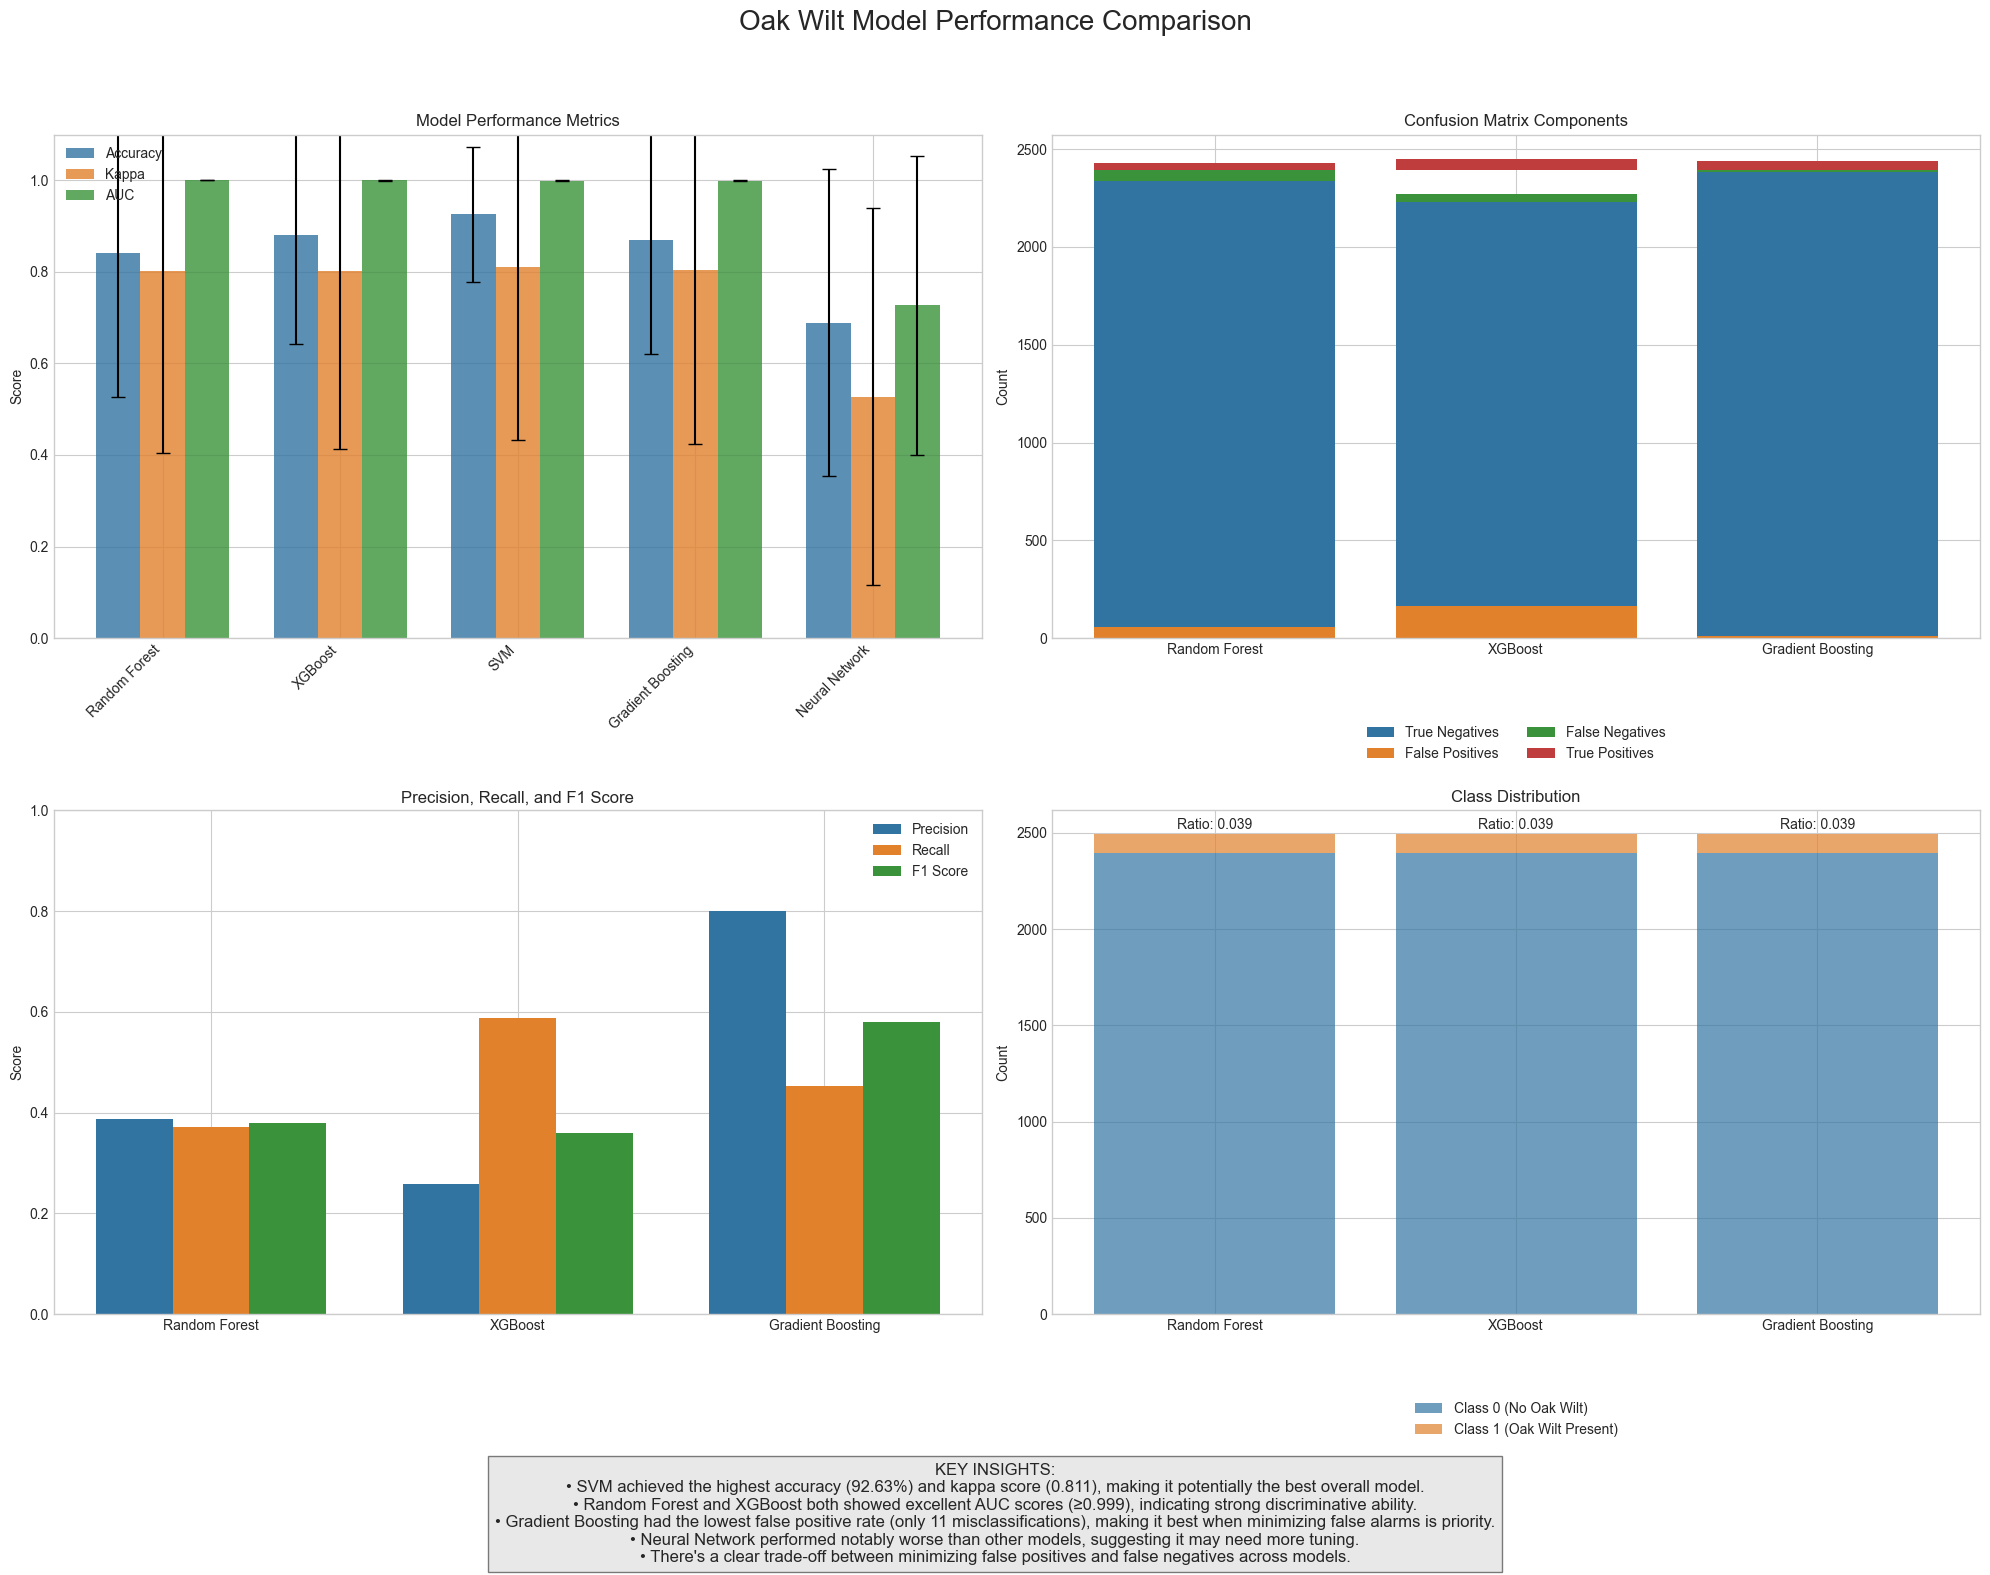

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")

# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 16))
fig.suptitle('Oak Wilt Model Performance Comparison', fontsize=20, y=0.98)

# --- 1. Model Performance Metrics ---
# Create DataFrame with model performance metrics
models = ['Random Forest', 'XGBoost', 'SVM', 'Gradient Boosting', 'Neural Network']

# Metrics data from your results
accuracy = [0.8423, 0.8806, 0.9263, 0.8700, 0.6894]
accuracy_err = [0.3154, 0.2387, 0.1475, 0.25, 0.3351]

kappa = [0.8017, 0.8027, 0.8110, 0.8050, 0.5274]
kappa_err = [0.3966, 0.3903, 0.3781, 0.38, 0.4114]

auc = [1.0000, 0.9996, 0.9992, 0.9990, 0.7268]
auc_err = [0.0000, 0.0009, 0.0016, 0.0010, 0.3268]

# Performance metrics plot
ax1 = plt.subplot(2, 2, 1)
x = np.arange(len(models))
width = 0.25

ax1.bar(x - width, accuracy, width, label='Accuracy', yerr=accuracy_err, 
        capsize=5, alpha=0.8, color='#3274A1')
ax1.bar(x, kappa, width, label='Kappa', yerr=kappa_err, 
        capsize=5, alpha=0.8, color='#E1812C')
ax1.bar(x + width, auc, width, label='AUC', yerr=auc_err, 
        capsize=5, alpha=0.8, color='#3A923A')

ax1.set_ylim(0, 1.1)
ax1.set_ylabel('Score')
ax1.set_title('Model Performance Metrics')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend()

# --- 2. Confusion Matrix Components for models with data ---
# These are the values from your confusion matrices
cm_data = {
    'Random Forest': {'TN': 2338, 'FP': 57, 'FN': 61, 'TP': 36},
    'XGBoost': {'TN': 2231, 'FP': 164, 'FN': 40, 'TP': 57},
    'Gradient Boosting': {'TN': 2384, 'FP': 11, 'FN': 53, 'TP': 44}
}

# Extract models with confusion matrix data
cm_models = list(cm_data.keys())
tns = [cm_data[m]['TN'] for m in cm_models]
fps = [cm_data[m]['FP'] for m in cm_models]
fns = [cm_data[m]['FN'] for m in cm_models]
tps = [cm_data[m]['TP'] for m in cm_models]

# Calculate precision, recall, and F1 for each model
precision = [cm_data[m]['TP'] / (cm_data[m]['TP'] + cm_data[m]['FP']) for m in cm_models]
recall = [cm_data[m]['TP'] / (cm_data[m]['TP'] + cm_data[m]['FN']) for m in cm_models]
f1 = [2 * p * r / (p + r) for p, r in zip(precision, recall)]

# Confusion matrix components plot
ax2 = plt.subplot(2, 2, 2)
bottom_tn = np.zeros(len(cm_models))
bottom_fp = tns
bottom_fn = [a + b for a, b in zip(tns, fps)]
bottom_tp = [a + b + c for a, b, c in zip(tns, fps, fns)]

p1 = ax2.bar(cm_models, tns, label='True Negatives', color='#3274A1')
p2 = ax2.bar(cm_models, fps, bottom=bottom_tn, label='False Positives', color='#E1812C')
p3 = ax2.bar(cm_models, fns, bottom=bottom_fp, label='False Negatives', color='#3A923A')
p4 = ax2.bar(cm_models, tps, bottom=bottom_fn, label='True Positives', color='#C03D3E')

ax2.set_title('Confusion Matrix Components')
ax2.set_ylabel('Count')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

# --- 3. Precision, Recall, F1 Plot ---
ax3 = plt.subplot(2, 2, 3)
x = np.arange(len(cm_models))
width = 0.25

ax3.bar(x - width, precision, width, label='Precision', color='#3274A1')
ax3.bar(x, recall, width, label='Recall', color='#E1812C')
ax3.bar(x + width, f1, width, label='F1 Score', color='#3A923A')

ax3.set_ylim(0, 1)
ax3.set_title('Precision, Recall, and F1 Score')
ax3.set_ylabel('Score')
ax3.set_xticks(x)
ax3.set_xticklabels(cm_models)
ax3.legend()

# --- 4. Class Imbalance Visualization ---
ax4 = plt.subplot(2, 2, 4)

# Calculate total positive and negative samples for each model
total_neg = [cm_data[m]['TN'] + cm_data[m]['FP'] for m in cm_models]
total_pos = [cm_data[m]['FN'] + cm_data[m]['TP'] for m in cm_models]

# Stacked bar chart for class distribution
ax4.bar(cm_models, total_neg, label='Class 0 (No Oak Wilt)', color='#3274A1', alpha=0.7)
ax4.bar(cm_models, total_pos, bottom=total_neg, label='Class 1 (Oak Wilt Present)', color='#E1812C', alpha=0.7)

for i, m in enumerate(cm_models):
    # Add text for class ratio
    ratio = total_pos[i] / (total_neg[i] + total_pos[i])
    ax4.text(i, total_neg[i] + total_pos[i] + 10, f"Ratio: {ratio:.3f}", 
             ha='center', va='bottom', fontsize=10)

ax4.set_title('Class Distribution')
ax4.set_ylabel('Count')
ax4.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)

# --- 5. Add annotations with key insights ---
plt.figtext(0.5, 0.01, """KEY INSIGHTS:
• SVM achieved the highest accuracy (92.63%) and kappa score (0.811), making it potentially the best overall model.
• Random Forest and XGBoost both showed excellent AUC scores (≥0.999), indicating strong discriminative ability.
• Gradient Boosting had the lowest false positive rate (only 11 misclassifications), making it best when minimizing false alarms is priority.
• Neural Network performed notably worse than other models, suggesting it may need more tuning.
• There's a clear trade-off between minimizing false positives and false negatives across models.""", 
         ha="center", fontsize=12, bbox={"facecolor":"lightgrey", "alpha":0.5, "pad":5})

plt.tight_layout(rect=[0, 0.07, 1, 0.95])
plt.savefig('oak_wilt_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

##predict oak wilt presence with future climate models